In [1]:
import pandas as pd
import spacy
import matplotlib.pyplot as plt
import math

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score

nlp = spacy.load("en_core_web_sm")

# import keyword analysis lib
%run Keyword_Analysis_Lib.ipynb

In [2]:
# read excel
data_path = "data//Code review w_ keyword 'refactor'  (Spring 2023).xlsx"
df = pd.read_excel(open(data_path, 'rb'), sheet_name='Manual labeling', usecols="A:E")  
df

,id,url,subject,description,Category
0,openstack%2Frally~master~I9da0124d5a644fccb6e6...,https://review.opendev.org/240219,Refactoring log utils,Refactoring log utils * Moved log functions f...,testing
1,openstack%2Frally~master~I9da0124d5a644fccb6e6...,https://review.opendev.org/240219,Refactoring log utils,Refactoring log utils * Moved log functions f...,objective
2,zuul%2Fzuul~master~Icbe206db6bcbaaf78a3d89997f...,https://review.opendev.org/223063,(WIP) Refactor for better connection testing,(WIP) Refactor for better connection testing ...,testing
3,zuul%2Fzuul~master~Icbe206db6bcbaaf78a3d89997f...,https://review.opendev.org/223063,(WIP) Refactor for better connection testing,(WIP) Refactor for better connection testing ...,objective
4,openstack%2Fhorizon~master~I5d2272a0abb521ddb9...,https://review.opendev.org/142839,Refactor project instance test,Refactor project instance test Refactoring th...,testing
...,...,...,...,...,...
3831,openstack%2Fmagnum~master~I6f880cb03ed43ec3bc9...,https://review.opendev.org/666669,k8s: refactor functions into KubernetesDriver,k8s: refactor functions into KubernetesDriver ...,integration
3832,openstack%2Fmagnum~master~I6f880cb03ed43ec3bc9...,https://review.opendev.org/666669,k8s: refactor functions into KubernetesDriver,k8s: refactor functions into KubernetesDriver ...,objective
3833,openstack%2Fneutron-tempest-plugin~master~I5ce...,https://review.opendev.org/673023,Refactor the test_qos.QoSTestMixin._check_bw f...,Refactor the test_qos.QoSTestMixin._check_bw f...,objective
3834,openstack%2Fneutron-tempest-plugin~master~I5ce...,https://review.opendev.org/673023,Refactor the test_qos.QoSTestMixin._check_bw f...,Refactor the test_qos.QoSTestMixin._check_bw f...,testing


<AxesSubplot:>

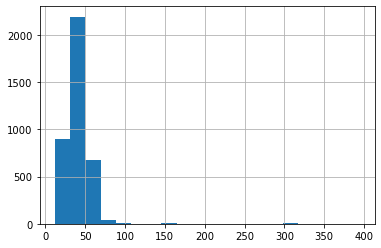

In [3]:
subj_length = df['subject'].str.len()
subj_length.hist(bins=20)

<AxesSubplot:>

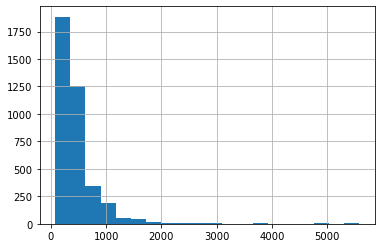

In [4]:
desc_length = df['description'].str.len()
desc_length.hist(bins=20)

<AxesSubplot:>

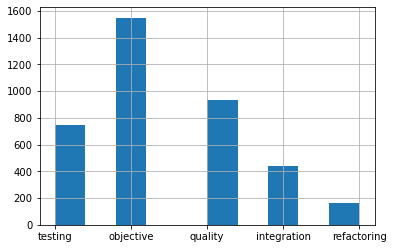

In [5]:
df['Category'].hist(bins=10)

In [6]:
%%time

# apply spacy nlp to all rows  
docs = [nlp(doc) for doc in list(df.description)]
docs_labels = [category for category in list(df.Category)]
docs[:3], docs_labels[:3]

CPU times: total: 43.7 s
Wall time: 45.5 s


([Refactoring log utils  * Moved log functions from rally/common/utils.py #L137-L234 to rally/common/log.y * Moved test tunctions form test/unit/common/test_utils.py to test/unit/common/test_log.py  Change-Id: I9da0124d5a644fccb6e6253951321a61ec973b03,
  Refactoring log utils  * Moved log functions from rally/common/utils.py #L137-L234 to rally/common/log.y * Moved test tunctions form test/unit/common/test_utils.py to test/unit/common/test_log.py  Change-Id: I9da0124d5a644fccb6e6253951321a61ec973b03,
  (WIP) Refactor for better connection testing  * Assign configured fake connections to test class dynamically  * Generalize event queue handling in tests  * Pass upstream_root to fake gerrit explicitly  * Don't pass fake_gerrit to FakeURLOpener  Change-Id: Icbe206db6bcbaaf78a3d89997f382c02079116c0],
 ['testing', 'objective', 'testing'])

In [15]:
%%time

# generate processed docs and count words
categories = ["integration","objective","quality","refactoring","testing"]
word_count = {}
word_count_category = {c:{} for c in categories}
doc_count = {}
p_docs = []
for doc_index in range(len(docs)):
    doc = docs[doc_index]
    category = docs_labels[doc_index]
    p_doc = " ".join([t.lemma_ for t in doc if t.is_alpha and not t.is_stop])
    p_docs.append(p_doc)
    for token in doc:
        if token.is_alpha and not token.is_stop:
            lemma = token.lemma_
            
             # general word count
            if lemma not in word_count:
                word_count[lemma] = 0
            word_count[lemma] += 1  
            
            # category specific count
            if lemma not in word_count_category[category]:
                word_count_category[category][lemma] = 0
            word_count_category[category][lemma] += 1  
            
for p_doc in p_docs:
    for lemma in set(p_doc.split(" ")):
        # general doc count
        if lemma not in doc_count:
            doc_count[lemma] = 0
        doc_count[lemma] += 1

CPU times: total: 219 ms
Wall time: 280 ms


In [16]:
display(docs[0])
display(p_docs[0])

Refactoring log utils  * Moved log functions from rally/common/utils.py #L137-L234 to rally/common/log.y * Moved test tunctions form test/unit/common/test_utils.py to test/unit/common/test_log.py  Change-Id: I9da0124d5a644fccb6e6253951321a61ec973b03

'refactoring log util move log function rally common rally common move test tunction form test unit common test unit common Change Id'

In [17]:
print("# Words:", len(word_count))
dict(sorted(word_count.items(), key=lambda item: item[1], reverse=True))

# Words: 5049


{'test': 5113,
 'Change': 3916,
 'Id': 3882,
 'refactor': 3147,
 'code': 1886,
 'function': 1698,
 'add': 1676,
 'change': 1556,
 'class': 1438,
 'patch': 1321,
 'method': 1291,
 'api': 1162,
 'use': 1147,
 'bug': 1132,
 'Refactor': 1018,
 'remove': 906,
 'file': 860,
 'case': 822,
 'new': 814,
 'unit': 809,
 'refactore': 797,
 'driver': 769,
 'fix': 671,
 'create': 647,
 'need': 639,
 'module': 603,
 'base': 603,
 'refactoring': 561,
 'update': 543,
 'commit': 488,
 'service': 478,
 'support': 477,
 'check': 472,
 'pass': 456,
 'call': 453,
 'move': 447,
 'set': 439,
 'instead': 438,
 'config': 438,
 'run': 434,
 'object': 425,
 'blueprint': 419,
 'common': 404,
 'functional': 404,
 'relate': 404,
 'network': 402,
 'implement': 389,
 'instance': 385,
 'verify': 383,
 'exist': 361,
 'allow': 359,
 'resource': 353,
 'work': 349,
 'logic': 333,
 'datum': 332,
 'image': 326,
 'server': 318,
 'package': 308,
 'client': 304,
 'delete': 303,
 'separate': 303,
 'handle': 296,
 'different': 29

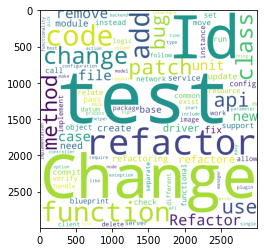

In [18]:
generate_wordcloud(word_count)

In [19]:
create_keyword_ctfidf(word_count_category, word_count, 10)

,integration,objective,quality,refactoring,testing
0,api: 0.082,test: 0.06,test: 0.058,function: 0.125,test: 0.126
1,Change: 0.057,Change: 0.058,Change: 0.058,Id: 0.104,Change: 0.061
2,Id: 0.057,Id: 0.057,Id: 0.058,Change: 0.104,Id: 0.06
3,refactor: 0.046,refactor: 0.051,refactor: 0.053,refactor: 0.078,refactor: 0.054
4,test: 0.037,function: 0.038,code: 0.048,code: 0.045,add: 0.04
5,change: 0.037,add: 0.037,function: 0.041,test: 0.031,unit: 0.037
6,patch: 0.034,code: 0.037,change: 0.034,,case: 0.035
7,Refactor: 0.03,change: 0.032,class: 0.032,,class: 0.034
8,add: 0.029,bug: 0.031,method: 0.03,,change: 0.034
9,class: 0.029,patch: 0.031,add: 0.03,,code: 0.033


In [12]:
# raw data

X_train, X_test, y_train, y_test = train_test_split(df['description'], df['Category'], test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train the model
model = MultinomialNB()
model.fit(X_train_vec, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_vec)

# Evaluate the performance of the model
acc = accuracy_score(y_test, y_pred)
print('Accuracy:', acc)

Accuracy: 0.4049479166666667


In [13]:
# preprocessed data


X_train, X_test, y_train, y_test = train_test_split(p_docs, df['Category'], test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train the model
model = MultinomialNB()
model.fit(X_train_vec, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_vec)

# Evaluate the performance of the model
acc = accuracy_score(y_test, y_pred)
print('Accuracy:', acc)

Accuracy: 0.3919270833333333


In [14]:
y_pred

array(['objective', 'objective', 'objective', 'objective', 'objective',
       'objective', 'objective', 'objective', 'quality', 'quality',
       'objective', 'objective', 'objective', 'objective', 'objective',
       'objective', 'objective', 'objective', 'quality', 'objective',
       'objective', 'objective', 'objective', 'objective', 'objective',
       'objective', 'objective', 'objective', 'objective', 'objective',
       'objective', 'objective', 'objective', 'quality', 'objective',
       'objective', 'objective', 'objective', 'objective', 'objective',
       'objective', 'objective', 'objective', 'objective', 'objective',
       'objective', 'objective', 'objective', 'objective', 'objective',
       'objective', 'objective', 'objective', 'objective', 'objective',
       'objective', 'objective', 'quality', 'objective', 'objective',
       'objective', 'objective', 'objective', 'objective', 'objective',
       'objective', 'objective', 'objective', 'objective', 'objective',
  